In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from PIL import Image

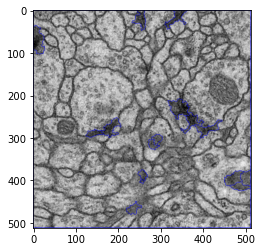

In [4]:
img = cv2.imread('C:\\Users\\Tom-G\\OneDrive\\3DOWN\\Bioinformatics\\Exp\\CASIA_MIRA\\ISBI_Dataset\\train\\train-volume00.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=2)  # sure background area
sure_fg = cv2.erode(opening, kernel, iterations=2)  # sure foreground area
unknown = cv2.subtract(sure_bg, sure_fg)  # unknown area

# Perform the distance transform algorithm
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# Normalize the distance image for range = {0.0, 1.0}
cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)

# Finding sure foreground area
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers_copy = markers.copy()
markers_copy[markers==0] = 150  # 灰色表示背景
markers_copy[markers==1] = 0    # 黑色表示背景
markers_copy[markers>1] = 255   # 白色表示前景

markers_copy = np.uint8(markers_copy)

# 使用分水岭算法执行基于标记的图像分割，将图像中的对象与背景分离
markers = cv2.watershed(img, markers)
img[markers==-1] = [0,0,255]  # 将边界标记为红色
plt.imshow(img)

In [21]:
def watershed_skimage():
    img = cv2.imread('C:\\Users\\Tom-G\\OneDrive\\3DOWN\\Bioinformatics\\Exp\\CASIA_MIRA\\ISBI_Dataset\\train\\train-volume00.jpg')
    from skimage.morphology import watershed
    from skimage import filters,util
    edges=filters.sobel(img)
    grid = util.regular_grid(img.shape, n_points=468)
    seeds = np.zeros(img.shape, dtype=int)
    seeds[grid] = np.arange(seeds[grid].size).reshape(seeds[grid].shape) + 1
    output=watershed(edges)
    fig,(ax1,ax2)=plt.subplots(1,2)
    ax1.imshow(img)
    ax2.imshow(output)
    plt.show()

D:\Env\Anaconda\envs\tfenv\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


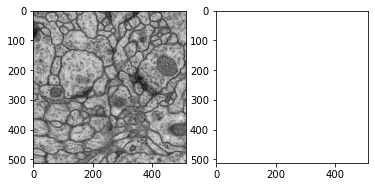

In [22]:
watershed_skimage()

c:\Users\Tom-G\OneDrive\3DOWN\Bioinformatics\Exp\L-FCN\Watershed.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])


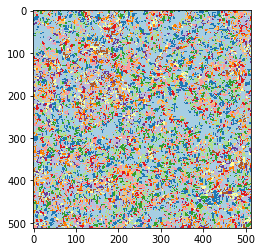

In [2]:
from Watershed import Watershed
img = np.array(Image.open('C:\\Users\\Tom-G\\OneDrive\\3DOWN\\Bioinformatics\\Exp\\CASIA_MIRA\\ISBI_Dataset\\train\\train-volume00.jpg'))
w=Watershed()
labels = w.apply(img)
plt.imshow(labels, cmap='Paired', interpolation='nearest')
plt.show()

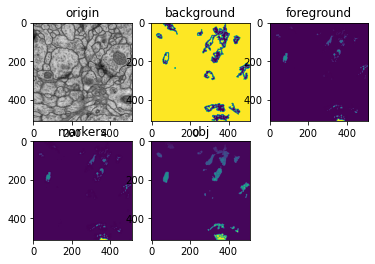

In [29]:
# -*- coding: UTF-8 -*-
import os
from scipy.ndimage import label, generate_binary_structure


def sobel(gray,size):
    #ksize是指核的大小,只能取奇数，影响边缘的粗细
    x = cv2.Sobel(gray,cv2.CV_16S,1,0,ksize=size)
    y = cv2.Sobel(gray,cv2.CV_16S,0,1,ksize=size)
    
    # 转回uint8
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)

    dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
    return dst

def canny(img):
    #拆分色彩通道
    b, g, r = cv2.split(img)
    #锐化
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)
    target_b = cv2.Canny(b, 200, 1200)
    target_g = cv2.Canny(g, 200, 1200)
    target_r = cv2.Canny(r, 200, 1200)
    target=cv2.add(target_b,target_g)
    target=cv2.add(target,target_r)
    return target



# os.chdir(os.path.dirname(__file__))

#因为真实的图片色彩难以区分低梯度图像的差异，因此用plt显示图片赋予对比明显的颜色
#生成画布
fig=plt.figure()



img = cv2.imdecode(np.fromfile('C:\\Users\\Tom-G\\OneDrive\\3DOWN\\Bioinformatics\\Exp\\CASIA_MIRA\\ISBI_Dataset\\train\\train-volume00.jpg', dtype=np.uint8), 1)
#生成子图，将画布分割成1行5列，图像画在从左到右从上到下的第1块
ax1=fig.add_subplot(231)
ax1.imshow(img)
ax1.set_title("origin")

#寻找文本边缘
edge=canny(img)

#确定未知区域
h_structure = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
d_edge = cv2.dilate(edge,h_structure,1)


#图片先转成灰度的
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#分水岭算法需要对背景、前景（目标）、未知区域进行标记。
#标记的数据类型必须是int32，否则后面会报错
#确定的背景标记为1
markers=np.ones_like(gray, dtype=np.int32)

#未知区域标记为0（黑色）
markers[np.where(d_edge==255)]=0
ax2=fig.add_subplot(232)
ax2.imshow(markers)
ax2.set_title("background")

#转换二值图
ret,binary=cv2.threshold(gray,240,255,cv2.THRESH_BINARY)
#反色
binary=cv2.bitwise_not(binary)

#去除小的区域
contours, hierarch=cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    #设定阈值
    if area < 20:
        cv2.drawContours(binary,[contours[i]],0,0,-1)

#确定前景种子区域
foreground=cv2.subtract(binary,d_edge)
#label是标签，该函数把图像背景标成0，其他封闭目标用从1开始的整数标记
#stats 是bounding box的信息，N*5的矩阵，行对应每个label，五列分别为[x0, y0, 宽度, 高度, 面积]
#centroids 是每个域的质心坐标
_, labels, stats, centroids = cv2.connectedComponentsWithStats(foreground)
#使背景标记为1
labels=labels+1

ax4=fig.add_subplot(233)
ax4.imshow(labels)
ax4.set_title("foreground")


#确定的前景目标标记为2、3、4......(不同目标标记为不同序号，方面后面进行粘连前景的分割)
markers[np.where(labels!=1)]=labels[np.where(labels!=1)]

ax5=fig.add_subplot(234)
ax5.imshow(markers)
ax5.set_title("markers")


#只接受三通道的图像
#分水岭变换的结果会保存在markers中
cv2.watershed(img,markers)



ax6=fig.add_subplot(235)
ax6.imshow(markers)
ax6.set_title("obj")

plt.show()